In [69]:
import matplotlib.pyplot as plt

In [3]:
from pyiron import Project

/u/system/SLES12/soft/pyiron/dev/anaconda3/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: NOT-A-GIT-REPOSITORY is an invalid version and will not be supported in a future release
  warnings.warn(


In [56]:
pr = Project('Structures')

# Some Code for the Structure Generation

The generation with RandSPG is straightforward, but relies on some heuristics concerning the atomic volume.  Restricting it to much will lead to a lot of discarded structures, because the minimum bond distance cannot be respected.  Allowing to large volume can lead to very "exotic", low density structures particularly at high symmetries that look more like extended molecules than bulk structures.

In [90]:
from logging import getLogger
log = getLogger()
from typing import Iterable, Optional, Tuple
from random import choices

from pyiron_base import Project
from pyiron_atomistics.atomistics.job.structurecontainer import StructureContainer
from pyiron_atomistics.atomistics.structure.structurestorage import StructureStorage
from pyiron_atomistics.atomistics.structure.has_structure import HasStructure

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

def shake(displacement=0.1):
    """
    Return a function that randomly displaces atoms in structures.

    Args:
        displacement (float): standard deviation of atomic displacement
    """
    def mod(structure):
        structure.positions += \
                np.random.normal(scale=displacement,
                                 size=structure.positions.shape)
        return structure
    return mod

def stretch(hydro: float = 0.05, shear: float = 0.005):
    """
    Return a function that strains structures.

    Random strains are drawn from a uniform distribution within the positive
    and negative limits given.

    Args:
        hydro (float): Maximum strain along normal axes
        shear (float): Maximum strain along shear axes
    """
    def mod(structure):
        E = shear * (2 * np.random.rand(3, 3) - 1)
        E = 0.5 * (E + E.T) # symmetrize
        np.fill_diagonal(E, hydro * (2*np.random.rand(3) - 1))
        structure.apply_strain(E)
        return structure
    return mod


def fill_container(source: HasStructure, sink: StructureContainer,
                   repetitions: int=4, combine: int=1,
                   modifiers=( (0.5, shake()), (0.5, stretch()) ),
                   min_dist=1.8):
    """
    Apply the given modifying functions on each structure in source and fill them into the sink.
    
    Modifiers is a list of pairs, where the first is the probability of the modifier being chosen.
    
    If combine > 1 pick multiple modifiers according to their probability and apply them combined.
    
    This function also checks that the given min_dist is respected.
    """
    ps, mods = zip(*modifiers)
    for structure in tqdm(source.iter_structures(),
                          total=source.number_of_structures):
        for _ in range(repetitions):
            for i in range(10):
                s = structure.copy()
                for mod in choices(mods, weights=ps, k=combine):
                    s = mod(s)
                sd = s.repeat(2)
                sd.pbc = [False, False, False]
                dist = sd.get_neighbors(
                        num_neighbors=1,
                        cutoff_radius=2*min_dist
                ).distances
                if (dist > min_dist).all():
                    sink.append(s)
                    break
            else:
                print("WARN: Tried 10 times to find a structures, but "
                      "min_dist is never satisfied.")
    return sink


def randspg(pr: Project, numbers_of_atoms: Iterable[int], atomic_volume: float,
            min_radius: float=2.2, name: Optional[str]=None,
            repetitions: int=2, volume_range: Tuple[float]=(0.9, 1.1),
            delete_existing_job=False,
            submit: bool=False,
            element: str='Mg'
) -> StructureContainer:
    """
    Run RandSPG jobs.

    Args:
        pr (Project): 
        numbers_of_atoms (iterable of int): number of atoms in unit cell
        atomic_volume (float): average atomic volume to sample
        min_radius (float): closest distance between two atoms that's allowed
        name (str): give extra name to job
        repetitions (int): how many to generate per spacegroup
        volume_range (tuple of floats): minimum and maximum allowed volumes
                                        (relative to number_of_atoms*atomic_volume)
        submit (bool): submit calculations to the cluster
        element (str): chemical symbol of the element to create structure for

    Returns:
        StructureContainer: job with all structures
    """
    spg_pr = pr.create_group(f"RandSPG{('_' + name) if name else ''}")
    cont = pr.create.job.StructureContainer(
            f"spg_{'_'.join(map(str, numbers_of_atoms))}{('_' + name) if name else ''}",
            delete_existing_job=delete_existing_job
    )
    for number_of_atoms in numbers_of_atoms:
        j = spg_pr.create.job.RandSpg(
                f'spg_{element}_{number_of_atoms}',
                delete_existing_job=delete_existing_job
        )
        if j.status.initialized:
            volume = atomic_volume * number_of_atoms
            j.input['composition'] = f'{element}{number_of_atoms}'
            j.input['spacegroups'] = '1-230'
            j.input['latticeMins'] = '{0}, {0}, {0}, 60, 60, 60'.format(min_radius)
            j.input['latticeMaxes'] = '{0}, {0}, {0},120,120,120'.format(
                                number_of_atoms * min_radius * volume_range[1]
            )
            j.input['minVolume'] = volume * volume_range[0]
            j.input['maxVolume'] = volume * volume_range[1]
            j.input['numOfEachSpgToGenerate'] = repetitions
            j.input['forceMostGeneralWyckPos'] = 'FALSE'
            j.input['setMinRadii'] = min_radius
            if submit:
                j.server.queue = 'cm'
                j.server.run_time = 10 * 60
                j.server.cores = 1
            j.run()
    spg_pr.wait_for_jobs(interval_in_s=30, max_iterations=45)
    for j in spg_pr.iter_jobs():
        for n, s in j.list_of_structures:
            s.info['name'] = n
            cont.append(s)
    cont.run()
    return cont

# list of unique multiplicities of wyckoff positions for each space group
# index directly with space group number, i.e. index 0 is invalid
# use when you do not want to set forceMostGeneralWyckPos or be smarter about the selection of space groups
wyckoff_multiplicities = [
        None,
        [1],
        [2, 1],
        [2, 1],
        [2],
        [4, 2],
        [2, 1],
        [2],
        [4, 2],
        [4],
        [4, 2, 1],
        [4, 2],
        [8, 4, 2],
        [4, 2],
        [4, 2],
        [8, 4],
        [4, 2, 1],
        [4, 2],
        [4, 2],
        [4],
        [8, 4],
        [8, 4, 2],
        [16, 8, 4],
        [8, 4, 2],
        [8, 4],
        [4, 2, 1],
        [4, 2],
        [4, 2],
        [4, 2],
        [4],
        [4, 2],
        [4, 2],
        [4, 2],
        [4],
        [4, 2],
        [8, 4, 2],
        [8, 4],
        [8, 4],
        [8, 4, 2],
        [8, 4],
        [8, 4],
        [8, 4],
        [16, 8, 4],
        [16, 8],
        [8, 4, 2],
        [8, 4],
        [8, 4],
        [8, 4, 2, 1],
        [8, 4, 2],
        [8, 4, 2],
        [8, 4, 2],
        [8, 4, 2],
        [8, 4],
        [8, 4, 2],
        [8, 4],
        [8, 4, 2],
        [8, 4],
        [8, 4],
        [8, 4, 2],
        [8, 4, 2],
        [8, 4],
        [8, 4],
        [8, 4],
        [16, 8, 4],
        [16, 8, 4],
        [16, 8, 4, 2],
        [16, 8, 4],
        [16, 8, 4],
        [16, 8, 4],
        [32, 16, 8, 4],
        [32, 16, 8],
        [16, 8, 4, 2],
        [16, 8, 4],
        [16, 8],
        [16, 8, 4],
        [4, 2, 1],
        [4],
        [4, 2],
        [4],
        [8, 4, 2],
        [8, 4],
        [4, 2, 1],
        [8, 4, 2],
        [8, 4, 2, 1],
        [8, 4, 2],
        [8, 4, 2],
        [8, 4, 2],
        [16, 8, 4, 2],
        [16, 8, 4],
        [8, 4, 2, 1],
        [8, 4, 2],
        [8, 4],
        [8, 4],
        [8, 4, 2],
        [8, 4, 2],
        [8, 4],
        [8, 4],
        [16, 8, 4, 2],
        [16, 8, 4],
        [8, 4, 2, 1],
        [8, 4, 2],
        [8, 4, 2],
        [8, 4, 2],
        [8, 4, 2],
        [8, 4, 2],
        [8, 4, 2],
        [8, 4],
        [16, 8, 4, 2],
        [16, 8, 4],
        [16, 8, 4],
        [16, 8],
        [8, 4, 2, 1],
        [8, 4, 2],
        [8, 4, 2],
        [8, 4, 2],
        [8, 4, 2, 1],
        [8, 4, 2],
        [8, 4, 2],
        [8, 4, 2],
        [16, 8, 4, 2],
        [16, 8, 4],
        [16, 8, 4, 2],
        [16, 8, 4],
        [16, 8, 4, 2, 1],
        [16, 8, 4, 2],
        [16, 8, 4, 2],
        [16, 8, 4, 2],
        [16, 8, 4, 2],
        [16, 8, 4, 2],
        [16, 8, 4, 2],
        [16, 8, 4],
        [16, 8, 4, 2],
        [16, 8, 4, 2],
        [16, 8, 4],
        [16, 8, 4, 2],
        [16, 8, 4],
        [16, 8, 4, 2],
        [16, 8, 4, 2],
        [16, 8, 4],
        [32, 16, 8, 4, 2],
        [32, 16, 8, 4],
        [32, 16, 8, 4],
        [32, 16, 8],
        [3, 1],
        [3],
        [3],
        [9, 3],
        [6, 3, 2, 1],
        [18, 9, 6, 3],
        [6, 3, 2, 1],
        [6, 3, 2, 1],
        [6, 3],
        [6, 3],
        [6, 3],
        [6, 3],
        [18, 9, 6, 3],
        [6, 3, 1],
        [6, 3, 2, 1],
        [6, 2],
        [6, 2],
        [18, 9, 3],
        [18, 6],
        [12, 6, 4, 3, 2, 1],
        [12, 6, 4, 2],
        [12, 6, 3, 2, 1],
        [12, 6, 4, 2],
        [36, 18, 9, 6, 3],
        [36, 18, 12, 6],
        [6, 3, 2, 1],
        [6],
        [6],
        [6, 3],
        [6, 3],
        [6, 2],
        [6, 3, 2, 1],
        [12, 6, 4, 3, 2, 1],
        [12, 6, 4, 2],
        [12, 6, 4, 3, 2, 1],
        [12, 6],
        [12, 6],
        [12, 6, 3],
        [12, 6, 3],
        [12, 6, 4, 2],
        [12, 6, 3, 2, 1],
        [12, 6, 4, 2],
        [12, 6, 4, 2],
        [12, 6, 2],
        [12, 6, 3, 2, 1],
        [12, 6, 4, 2],
        [12, 6, 4, 3, 2, 1],
        [12, 6, 4, 2],
        [24, 12, 6, 4, 3, 2, 1],
        [24, 12, 8, 6, 4, 2],
        [24, 12, 8, 6, 4, 2],
        [24, 12, 6, 4, 2],
        [12, 6, 4, 3, 1],
        [48, 24, 16, 4],
        [24, 12, 8, 6, 2],
        [12, 4],
        [24, 12, 8],
        [24, 12, 8, 6, 3, 1],
        [24, 12, 8, 6, 4, 2],
        [96, 48, 32, 24, 8, 4],
        [96, 48, 32, 16, 8],
        [48, 24, 16, 12, 8, 6, 2],
        [24, 8, 4],
        [48, 24, 16, 8],
        [24, 12, 8, 6, 3, 1],
        [24, 12, 8, 6, 4, 2],
        [96, 48, 32, 24, 8, 4],
        [96, 48, 32, 16, 8],
        [48, 24, 16, 12, 8, 6, 2],
        [24, 12, 8, 4],
        [24, 12, 8, 4],
        [48, 24, 16, 12, 8],
        [24, 12, 6, 4, 3, 1],
        [96, 48, 24, 16, 4],
        [48, 24, 12, 8, 6, 2],
        [24, 12, 8, 6, 2],
        [96, 48, 32, 24, 8],
        [48, 24, 16, 12],
        [48, 24, 12, 8, 6, 3, 1],
        [48, 24, 16, 12, 8, 6, 2],
        [48, 24, 16, 12, 8, 6, 2],
        [48, 24, 12, 8, 6, 4, 2],
        [192, 96, 48, 32, 24, 8, 4],
        [192, 96, 64, 48, 24, 8],
        [192, 96, 48, 32, 16, 8],
        [192, 96, 64, 48, 32, 16],
        [96, 48, 24, 16, 12, 8, 6, 2],
        [96, 48, 32, 24, 16]
]

In [57]:
randspg?

Signature:
randspg(
    pr: pyiron_base.project.generic.Project,
    numbers_of_atoms: Iterable[int],
    atomic_volume: float,
    min_radius: float = 2.2,
    name: Union[str, NoneType] = None,
    repetitions: int = 2,
    volume_range: Tuple[float] = (0.9, 1.1),
    delete_existing_job=False,
    submit: bool = False,
    element: str = 'Mg',
) -> pyiron_atomistics.atomistics.job.structurecontainer.StructureContainer
Docstring:
Run RandSPG jobs.

Args:
    pr (Project): 
    numbers_of_atoms (iterable of int): number of atoms in unit cell
    atomic_volume (float): average atomic volume to sample
    min_radius (float): closest distance between two atoms that's allowed
    name (str): give extra name to job
    repetitions (int): how many to generate per spacegroup
    volume_range (tuple of floats): minimum and maximum allowed volumes
                                    (relative to number_of_atoms*atomic_volume)
    submit (bool): submit calculations to the cluster
    element (s

The number of atoms allowed in each unit cell naturally determines which space groups can be generated and in general more atoms allow for more sampled phase space.
At least 16 atoms are necessary to have a chance to see all symmetries.

In [73]:
max(min(w) for w in wyckoff_multiplicities[1:])

16

In the paper we include up to 10 atoms and find the resulting potentials general enough.

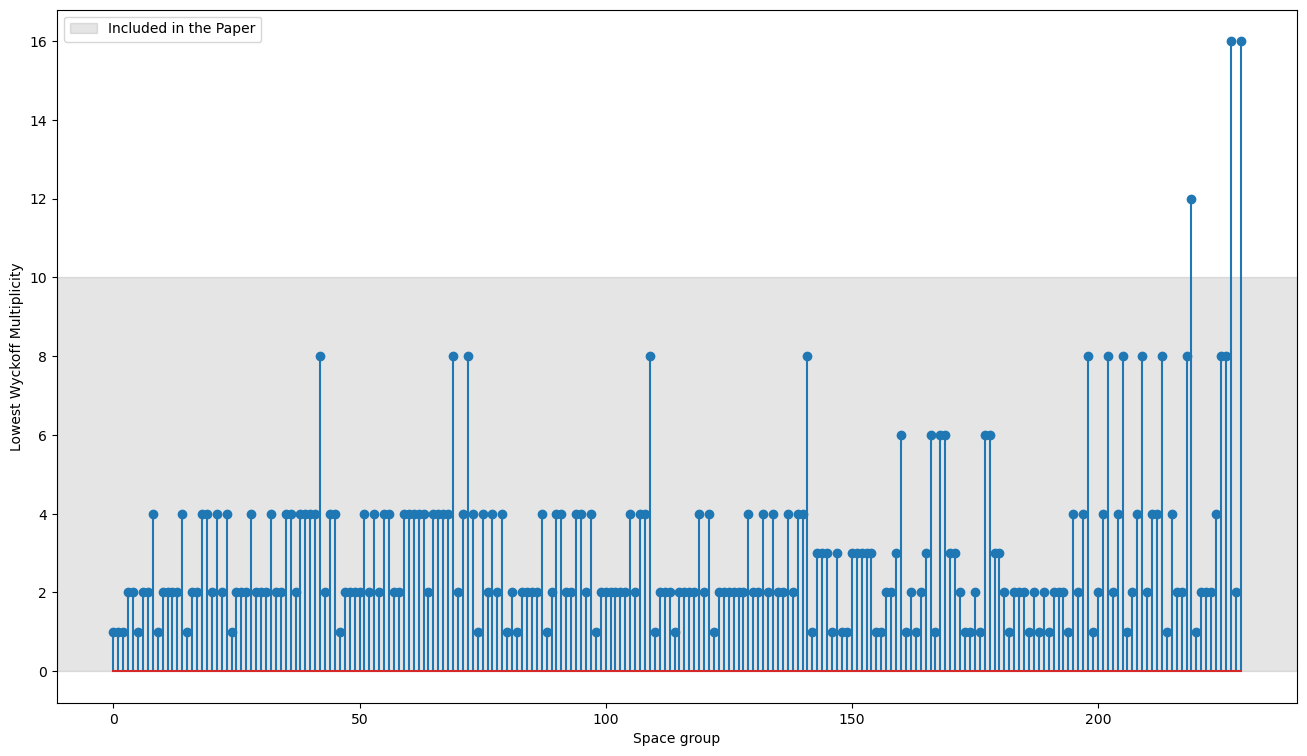

In [83]:
plt.stem([min(w) for w in wyckoff_multiplicities[1:]])
plt.xlabel('Space group')
plt.ylabel('Lowest Wyckoff Multiplicity')
plt.axhspan(0, 10, color='k', alpha=0.1, label='Included in the Paper')
plt.legend();

Including enough atoms to guarantee all symmetries would be significantly more challanging.

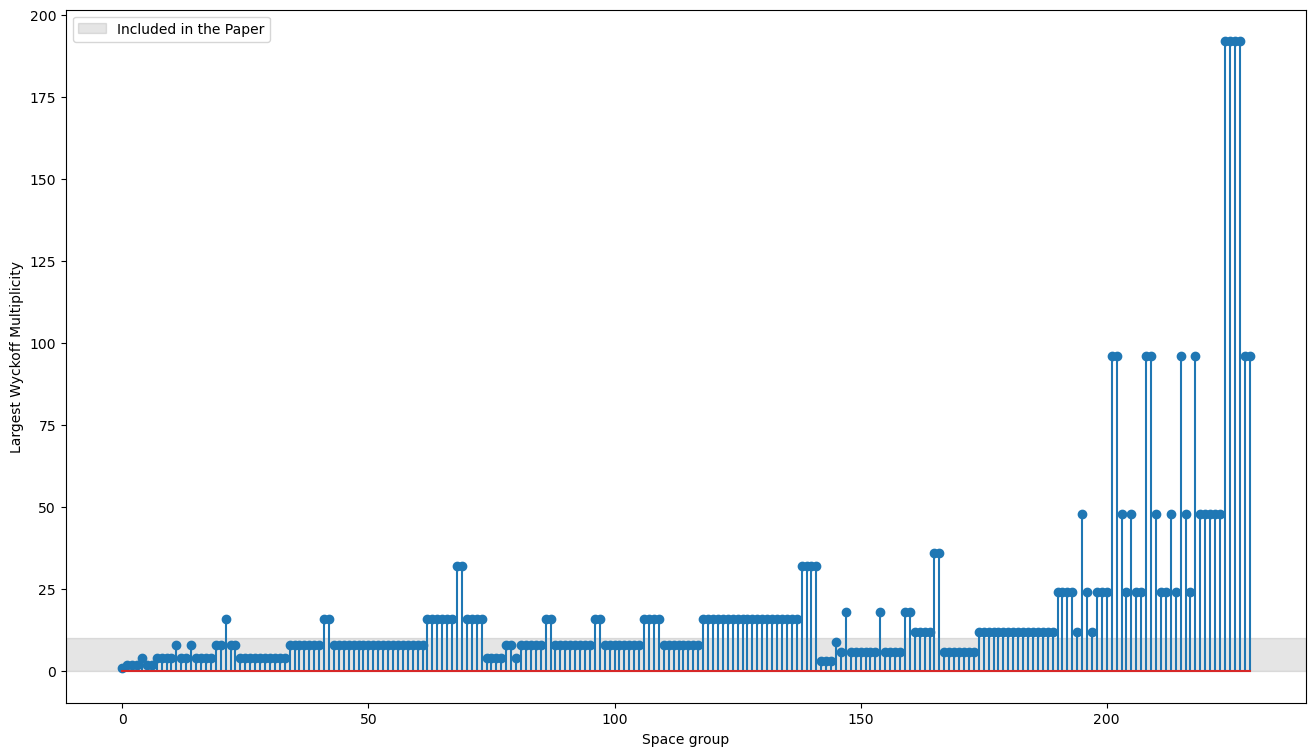

In [82]:
plt.stem([max(w) for w in wyckoff_multiplicities[1:]])
plt.xlabel('Space group')
plt.ylabel('Largest Wyckoff Multiplicity')
plt.axhspan(0, 10, color='k', alpha=0.1, label='Included in the Paper')
plt.legend();

For the demonstration here we'll restrict ourselves to four atoms.

In [60]:
spg = randspg(pr, [1, 2, 3, 4], atomic_volume=25, min_radius=1.5, repetitions=1, element='Mg')

The job spg_Mg_1 was saved and received the ID: 18394837
The job spg_Mg_2 was saved and received the ID: 18394838
The job spg_Mg_3 was saved and received the ID: 18394839
The job spg_Mg_4 was saved and received the ID: 18394840


  0%|          | 0/4 [00:00<?, ?it/s]

The job spg_1_2_3_4 was saved and received the ID: 18394841


## Visualizations

,a,b,c,alpha,beta,gamma,V,N
0,4.353890,4.353890,4.312684,90.0,90.0,90.000000,81.752775,3
1,4.882711,4.882711,3.340925,120.0,90.0,90.000000,68.979396,3
2,4.719098,4.719098,3.975308,120.0,90.0,90.000000,76.668944,3
3,4.883997,4.883997,3.819274,120.0,90.0,90.000000,78.897308,3
4,4.696134,4.396171,4.275934,90.0,90.0,68.734785,82.266093,3
...,...,...,...,...,...,...,...,...
178,5.353928,5.353928,3.695914,90.0,90.0,90.000000,105.941716,4
179,4.953451,5.269424,3.576137,90.0,90.0,90.000000,93.343755,4
180,5.402087,5.402087,3.411413,90.0,90.0,90.000000,99.553714,4
181,4.908837,4.908837,4.349776,90.0,90.0,90.000000,104.815139,4


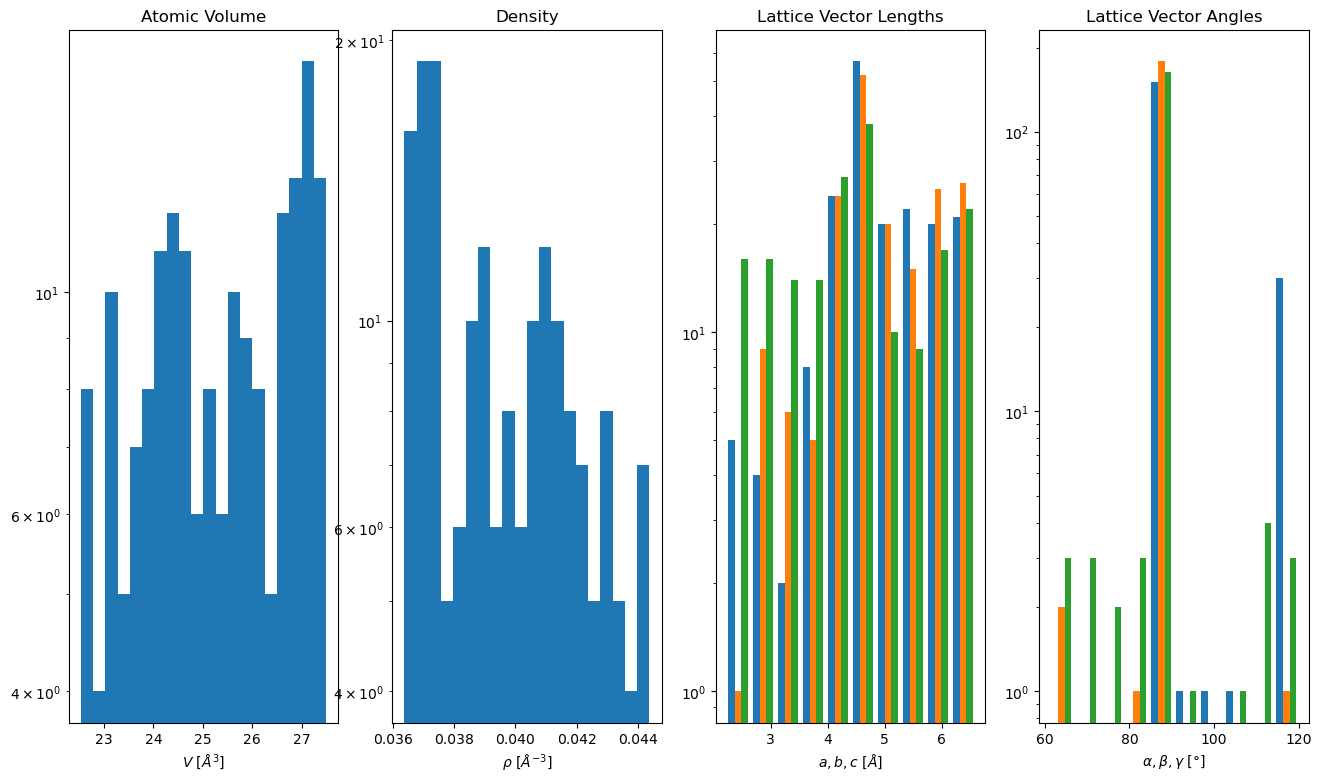

In [61]:
spg.plot.cell()

This plot shows how often each coordination is observed in each neighborhood shell in the generated data set.

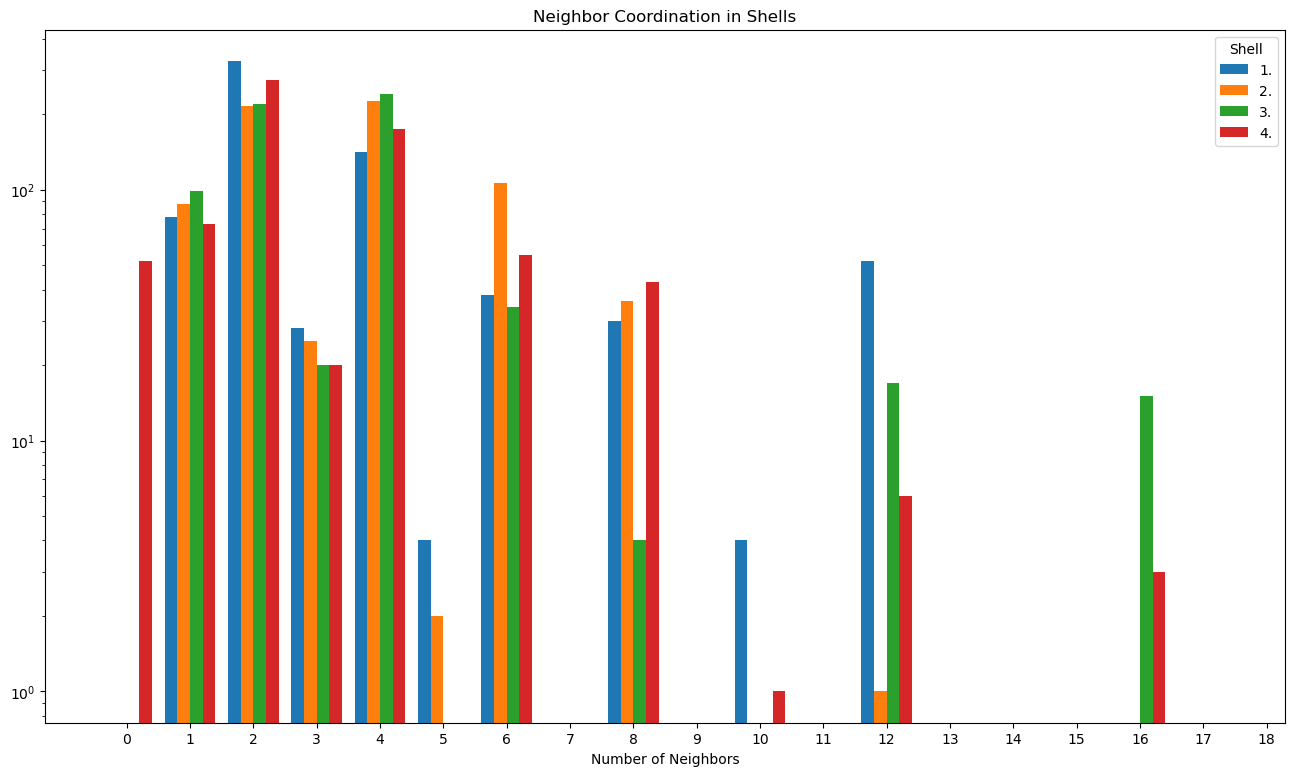

In [62]:
spg.plot.coordination()

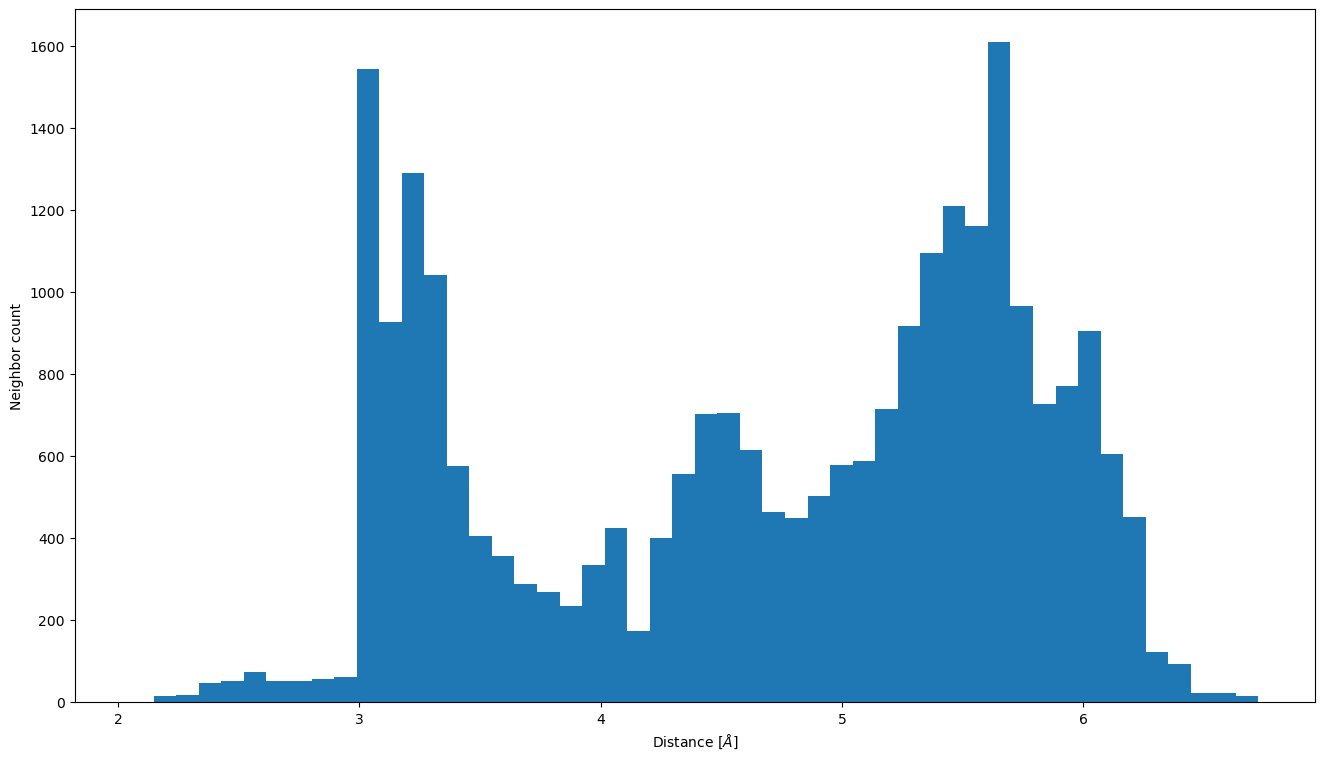

In [63]:
spg.plot.distances()

This plot seperates the histogram from above into contributions from each neighborhood shell.  Due to random dataset we cannot observe a lot of structure here, but using this plot for minimized structures allows to infer preferred bonding distances for the target material system.

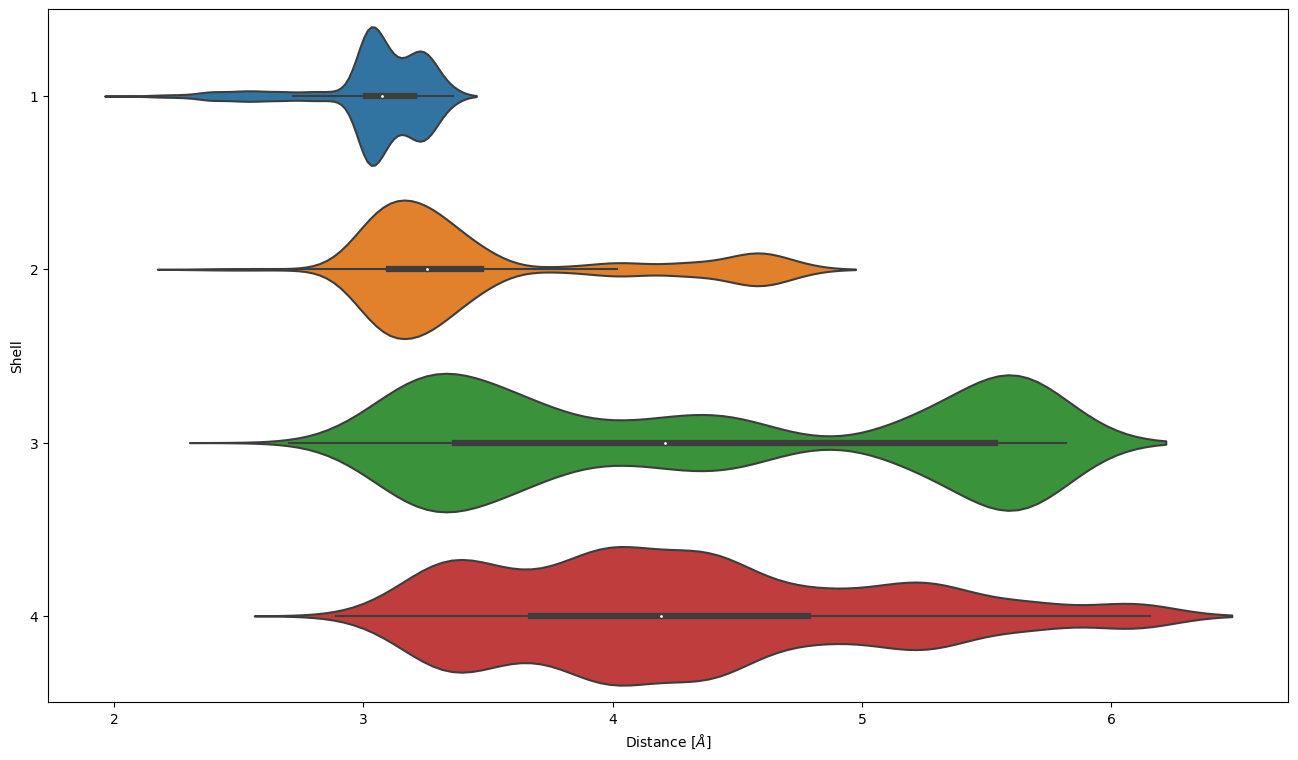

In [64]:
spg.plot.shell_distances()

This plot simply shows the spacegroup of each structure as determined by `spglib` after the generation with `RandSPG`.  Because of the low number of atoms in these structures we see some space groups missing and others degenerate, but even this small set can cover all crystal systems.

,space_group,crystal_system
0,123,tetragonal
1,166,trigonal
2,166,trigonal
3,145,trigonal
4,10,monoclinic
...,...,...
178,129,tetragonal
179,69,orthorhombic
180,139,tetragonal
181,139,tetragonal


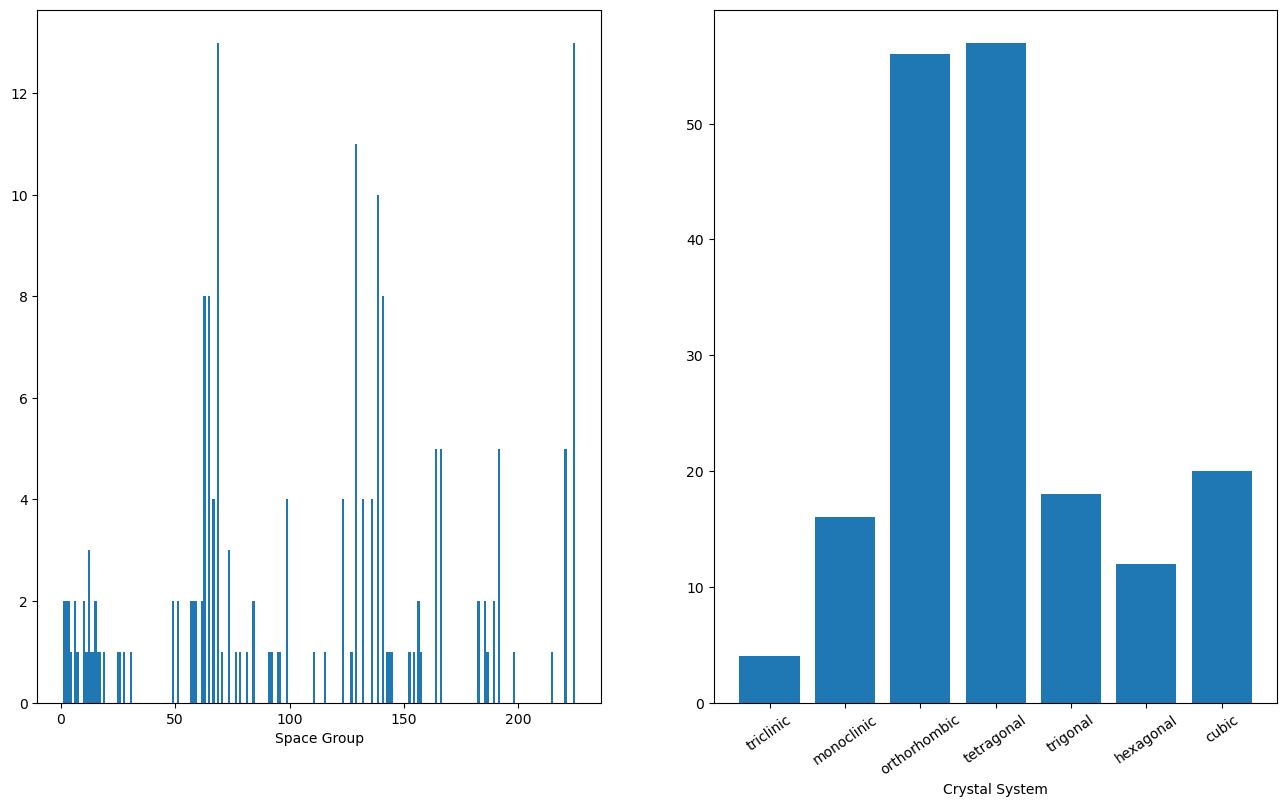

In [65]:
spg.plot.spacegroups()

# Modify Structures with Random Noise

In the paper we apply a minization inbetween generating the structures with RandSPG and shuffling them, but the idea is the same.

In [66]:
fill_container?

Signature:
fill_container(
    source: pyiron_atomistics.atomistics.structure.has_structure.HasStructure,
    sink: pyiron_atomistics.atomistics.job.structurecontainer.StructureContainer,
    repetitions: int = 4,
    combine: int = 1,
    modifiers=((0.5, <function shake.<locals>.mod at 0x14c474139b80>), (0.5, <function stretch.<locals>.mod at 0x14c474139af0>)),
    min_dist=1.8,
)
Docstring: <no docstring>
File:      /tmp/ipykernel_22621/835345881.py
Type:      function


In [85]:
hydro = pr.create.job.StructureContainer('Hydro')

In [86]:
stretch?

Signature: stretch(hydro: float = 0.05, shear: float = 0.005)
Docstring:
Return a function that strains structures.

Random strains are drawn from a uniform distribution within the positive
and negative limits given.

Args:
    hydro (float): Maximum strain along normal axes
    shear (float): Maximum strain along shear axes
File:      /tmp/ipykernel_22621/2737925604.py
Type:      function


In [91]:
hydro = fill_container(spg, hydro, repetitions=1, modifiers=((1, stretch(hydro=.5, shear=0)),))

  0%|          | 0/183 [00:00<?, ?it/s]

/u/zora/software/pyiron_atomistics/pyiron_atomistics/atomistics/structure/neighbors.py:284: UserWarning: Number of neighbors found within the cutoff_radius is equal to (estimated) num_neighbors. Increase num_neighbors (or set it to None) or width_buffer to find all neighbors within cutoff_radius.
  warnings.warn(


,a,b,c,alpha,beta,gamma,V,N
0,4.960605,5.485597,6.165807,90.0,90.0,90.000000,167.783202,3
1,5.342232,3.496475,2.394973,120.0,90.0,90.000000,38.742225,3
2,4.599969,3.857082,5.471903,120.0,90.0,90.000000,84.078087,3
3,4.976591,5.108678,4.672219,120.0,90.0,90.000000,102.871310,3
4,4.806225,6.095228,5.337936,90.0,90.0,68.734785,145.727704,3
...,...,...,...,...,...,...,...,...
178,4.749360,5.299753,3.264368,90.0,90.0,90.000000,82.165552,4
179,3.543440,2.797204,2.269322,90.0,90.0,90.000000,22.492899,4
180,3.802511,7.991723,3.014823,90.0,90.0,90.000000,91.616283,4
181,5.667725,4.727842,2.960081,90.0,90.0,90.000000,79.318666,4


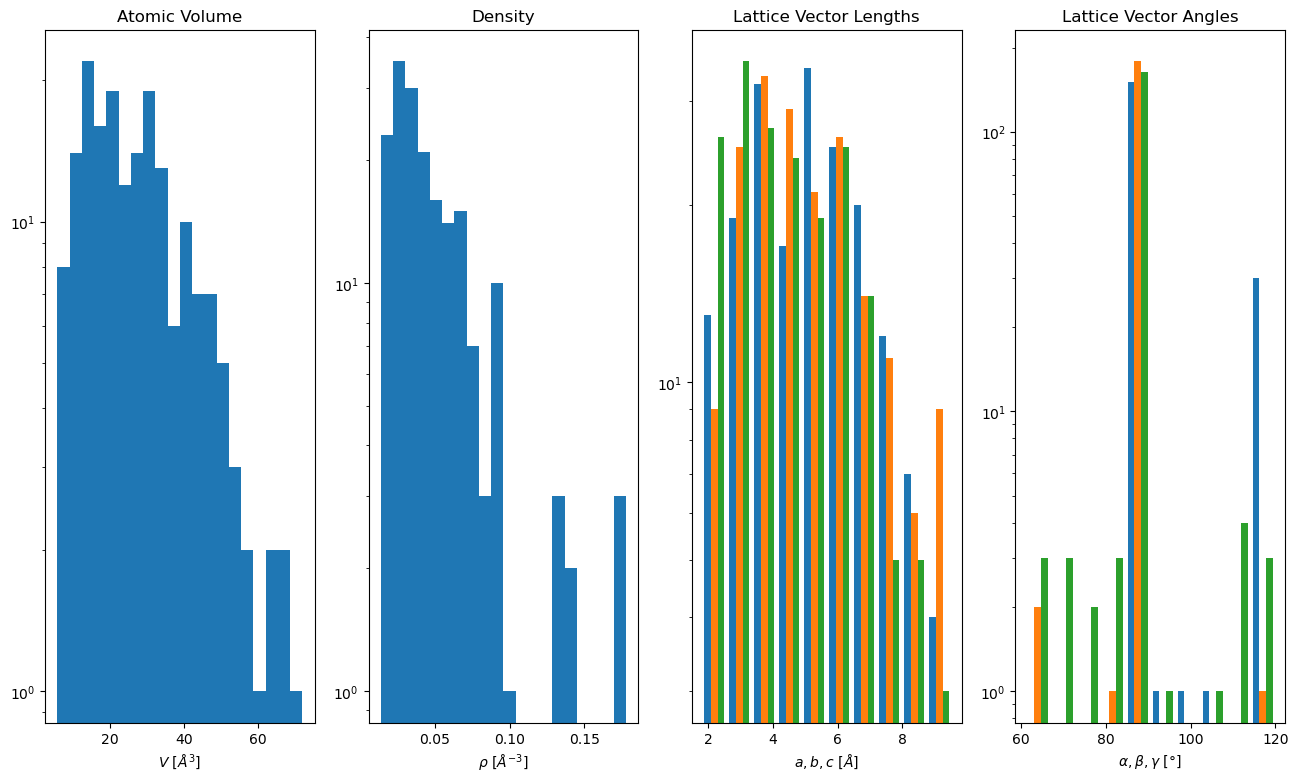

In [93]:
hydro.plot.cell()

In [94]:
shear = pr.create.job.StructureContainer('Shear')

In [95]:
shear = fill_container(spg, shear, repetitions=1, modifiers=((1, stretch(hydro=0, shear=0.05)),))

  0%|          | 0/183 [00:00<?, ?it/s]

/u/zora/software/pyiron_atomistics/pyiron_atomistics/atomistics/structure/neighbors.py:284: UserWarning: Number of neighbors found within the cutoff_radius is equal to (estimated) num_neighbors. Increase num_neighbors (or set it to None) or width_buffer to find all neighbors within cutoff_radius.
  warnings.warn(


,a,b,c,alpha,beta,gamma,V,N
0,4.354580,4.354964,4.314182,89.056676,92.370289,88.194308,81.690797,3
1,4.892912,4.891539,3.345885,120.351350,88.002242,94.473263,68.892995,3
2,4.712079,4.712839,3.976458,119.695130,87.594459,90.419944,76.632505,3
3,4.872449,4.872460,3.819385,119.523854,90.535297,90.434461,78.889982,3
4,4.712058,4.399505,4.290906,85.963832,88.542063,67.810687,82.161436,3
...,...,...,...,...,...,...,...,...
178,5.354377,5.354062,3.697678,89.927515,88.748229,87.705508,105.893515,4
179,4.953920,5.270869,3.580850,90.996696,93.968677,91.658142,93.220305,4
180,5.402635,5.403443,3.418282,89.337532,94.362376,92.640761,99.391303,4
181,4.910205,4.908951,4.351704,90.607952,90.541631,92.993453,104.739001,4


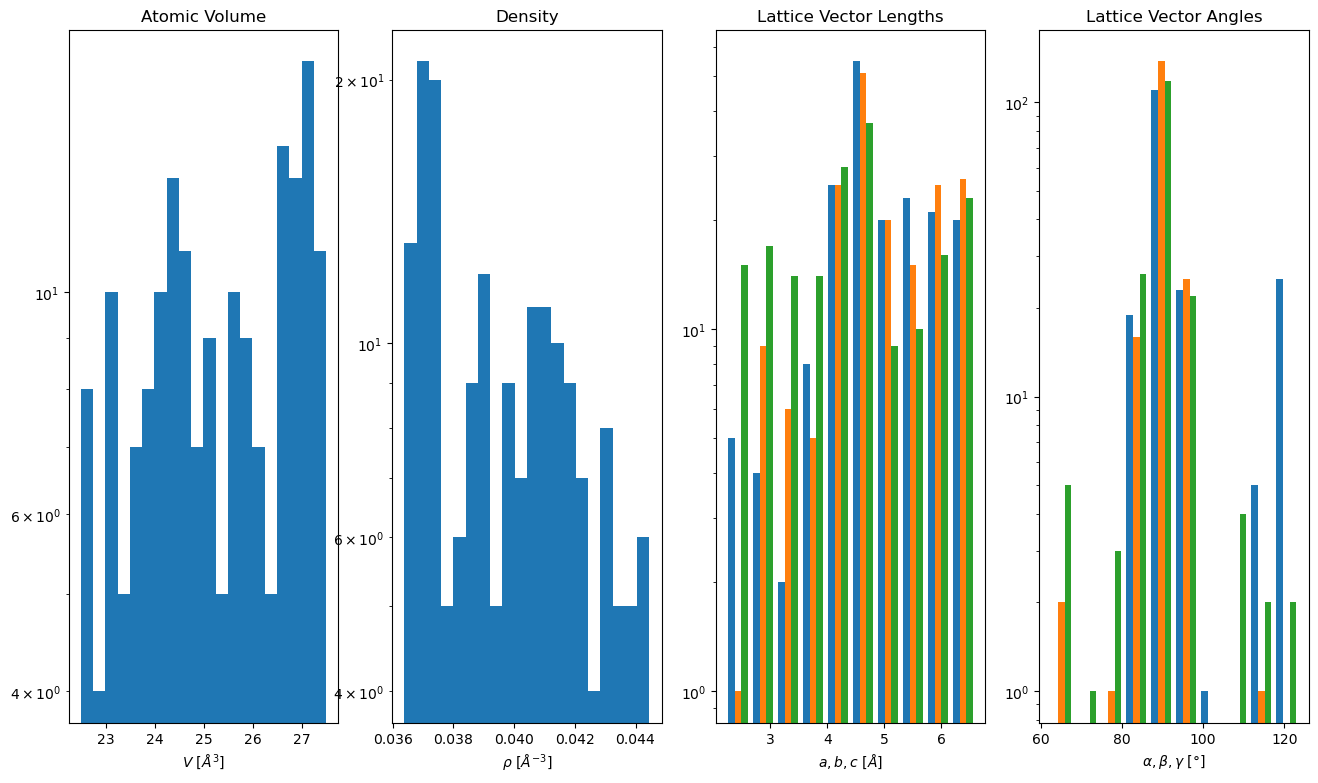

In [96]:
shear.plot.cell()

In [97]:
rattle = pr.create.job.StructureContainer('Rattle')

In [98]:
shake?

Signature: shake(displacement=0.1)
Docstring:
Return a function that randomly displaces atoms in structures.

Args:
    displacement (float): standard deviation of atomic displacement
File:      /tmp/ipykernel_22621/1297418615.py
Type:      function


In [100]:
rattle = fill_container(spg, rattle, repetitions=1, combine=2, modifiers=( (0.75, shake(0.05)), (0.25, stretch(hydro=0.01, shear=0.005)) ) )

  0%|          | 0/183 [00:00<?, ?it/s]

/u/zora/software/pyiron_atomistics/pyiron_atomistics/atomistics/structure/neighbors.py:284: UserWarning: Number of neighbors found within the cutoff_radius is equal to (estimated) num_neighbors. Increase num_neighbors (or set it to None) or width_buffer to find all neighbors within cutoff_radius.
  warnings.warn(


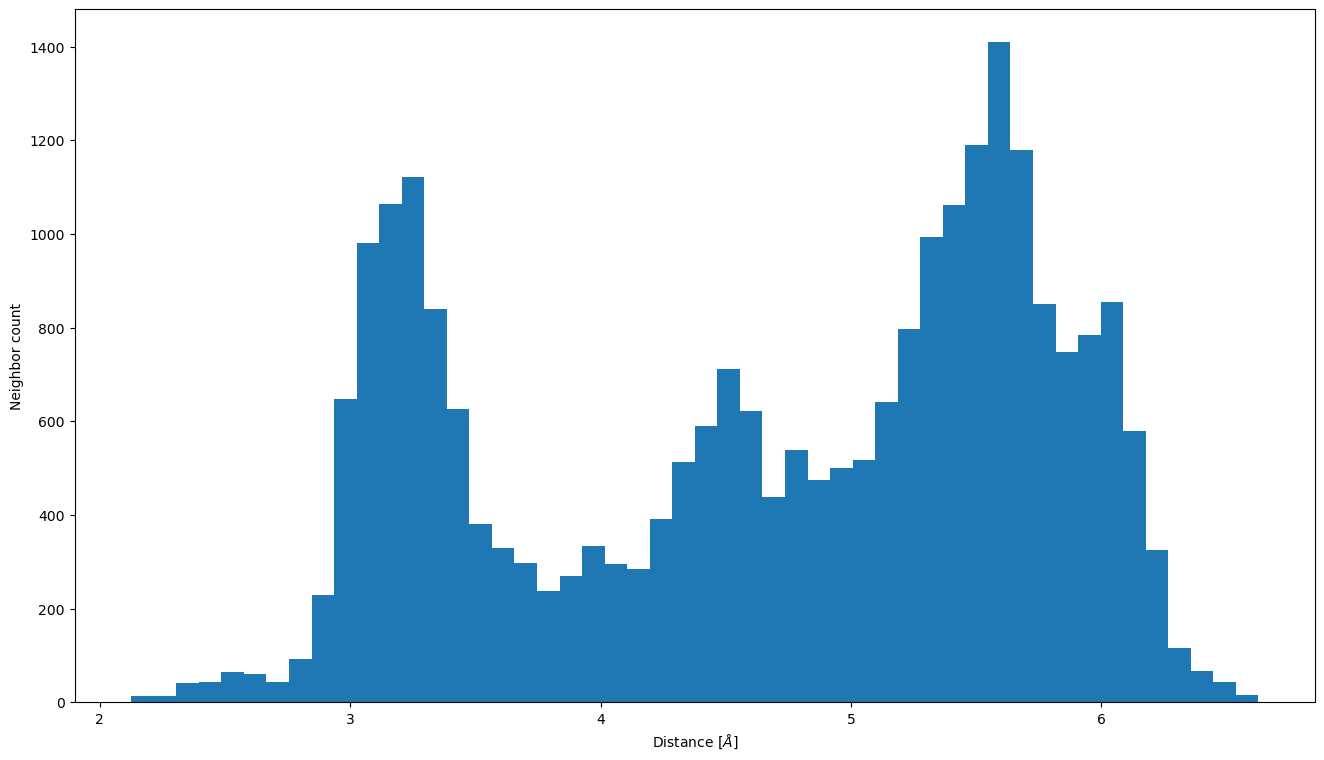

In [102]:
rattle.plot.distances()

,a,b,c,alpha,beta,gamma,V,N
0,4.353890,4.353890,4.312684,90.000000,90.000000,90.000000,81.752775,3
1,4.882711,4.882711,3.340925,120.000000,90.000000,90.000000,68.979396,3
2,4.702632,4.726165,3.997532,120.211586,89.985925,89.932429,76.778937,3
3,4.883997,4.883997,3.819274,120.000000,90.000000,90.000000,78.897308,3
4,4.651895,4.368306,4.300531,90.075585,90.030949,68.575140,81.351665,3
...,...,...,...,...,...,...,...,...
178,5.321865,5.380775,3.712178,90.200657,90.326893,89.991823,106.298636,4
179,4.994967,5.268091,3.562414,89.990116,90.286683,89.555069,93.737160,4
180,5.402087,5.402087,3.411413,90.000000,90.000000,90.000000,99.553714,4
181,4.908837,4.908837,4.349776,90.000000,90.000000,90.000000,104.815139,4


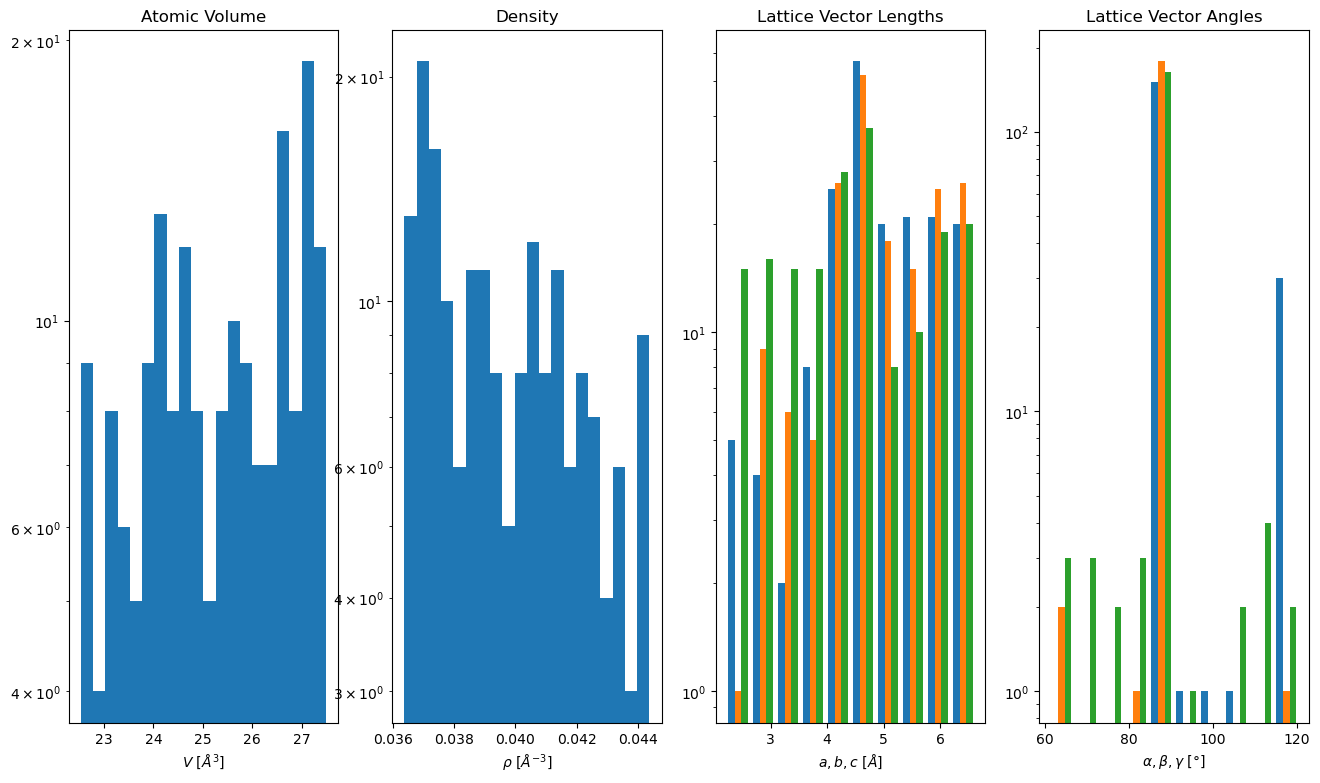

In [101]:
rattle.plot.cell()